In [129]:
import os
import numpy as np
import scanpy as sc
import pandas as pd
import xarray as xr
from numpy import ones
from pandas_plink import read_plink1_bin
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import time
from limix.qc import quantile_gaussianize

In [130]:
import cellregmap
cellregmap 

<module 'cellregmap' from '/share/ScratchGeneral/anncuo/github_repos/CellRegMap/cellregmap/__init__.py'>

In [131]:
from cellregmap import estimate_betas

In [132]:
chrom = 20

In [133]:
mydir = "/share/ScratchGeneral/anncuo/OneK1K/"
input_files_dir = "/share/ScratchGeneral/anncuo/OneK1K/input_files_CellRegMap/"

In [134]:
## sample mapping file
## this file will map cells to donors 
## here, Monocytes only
sample_mapping_file = input_files_dir+"smf_monocytes.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"individual_long": str, "genotype_individual_id": str, "phenotype_sample_id": str}, index_col=0)

In [135]:
sample_mapping.head()

,phenotype_sample_id,genotype_individual_id,individual_long
1,AAACGGGCACTTAAGC-1,684,683_684
2,AAACGGGTCTTGTTTG-1,694,693_694
3,AAAGATGAGTACGACG-1,690,689_690
4,AAAGATGGTGTGAATA-1,693,692_693
5,AAAGATGTCAAACAAG-1,683,682_683


In [136]:
## extract unique individuals
donors0 = sample_mapping["genotype_individual_id"].unique()
donors0.sort()
print("Number of unique donors: {}".format(len(donors0)))

Number of unique donors: 980


In [137]:
#### kinship file

In [138]:
## read in GRM (genotype relationship matrix; kinship matrix)
kinship_file="/share/ScratchGeneral/anncuo/OneK1K/input_files_CellRegMap/grm_wide.csv"
K = pd.read_csv(kinship_file, index_col=0)
K.index = K.index.astype('str')
assert all(K.columns == K.index) #symmetric matrix, donors x donors

/share/ScratchGeneral/anncuo/jupyter/conda_notebooks/envs/cellregmap_notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [139]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors0))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 980


In [140]:

## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

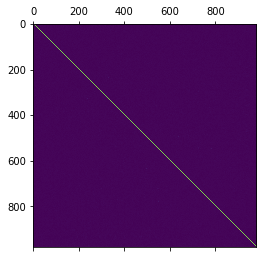

In [141]:
plt.matshow(K)

In [142]:
## and decompose such as K = hK @ hK.T (using Cholesky decomposition)
hK = cholesky(K.values)
hK = xr.DataArray(hK, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(hK.sample.values == K.sample_0.values)

In [143]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
## subsample sample mapping file to donors in the kinship matrix
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 53399
Sample mapping number of rows AFTER intersection: 53399


In [144]:
## use sel from xarray to expand hK (using the sample mapping file)
hK_expanded = hK.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [145]:
hK_expanded.shape

(53399, 980)

In [146]:
#### phenotype file

In [147]:
# open anndata 
my_file = "/share/ScratchGeneral/anncuo/OneK1K/expression_objects/sce"+str(chrom)+".h5ad"
adata = sc.read(my_file)
# sparse to dense
mat = adata.raw.X.todense()
# make pandas dataframe
mat_df = pd.DataFrame(data=mat.T, index=adata.raw.var.index, columns=adata.obs.index)
# turn into xr array
phenotype = xr.DataArray(mat_df.values, dims=["trait", "cell"], coords={"trait": mat_df.index.values, "cell": mat_df.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)

In [148]:
del mat
del mat_df

In [149]:
phenotype.shape

(617, 53399)

In [150]:
phenotype.head()

<xarray.DataArray (trait: 5, cell: 5)>
array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.69314718, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])
Coordinates:
  * trait    (trait) object 'AL136531.1' 'JAG1' 'AL035252.1' 'TTLL9' 'RBL1'
  * cell     (cell) object 'AAACGGGCACTTAAGC-1' ... 'AAAGATGTCAAACAAG-1'

In [151]:
#### genotype file

In [152]:
## read in genotype file (plink format)
plink_folder = "/share/ScratchGeneral/anncuo/OneK1K/plink_files/"
plink_file = plink_folder+"plink_chr"+str(chrom)+".bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 11.35it/s]


In [153]:
G

<xarray.DataArray 'genotype' (sample: 1034, variant: 118935)>
dask.array<transpose, shape=(1034, 118935), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object '1_1' '2_2' '3_3' ... '1103_926_2' '1104_920_2'
  * variant  (variant) <U13 'variant0' 'variant1' ... 'variant118934'
    fid      (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) object '1_1' '2_2' '3_3' ... '1103_926_2' '1104_920_2'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '20' '20' '20' '20' '20' ... '20' '20' '20' '20'
    snp      (variant) object '20:61098' '20:61795' ... '20:62917729'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pos      (variant) int32 61098 61795 63244 ... 62916494 62917667 62917729
    a0       (variant) object 'T' 'T' 'C' 'T' 'A' 'A' ... 'T' 'A' 'T' 'T' 'T'
    a1       (variant) object 'C' 'G' 'A' 'C' 'G' 'G' ... 'A' 'G' 'C' 'C' 'C'

In [154]:
G.shape

(1034, 118935)

In [155]:
# change this to select known eQTLs instead

In [156]:
# Filter on specific gene-SNP pairs
# eQTL from Monocytes (Mono NC + Mono C)
mono_eqtl_file = input_files_dir+"sex_beta_fvf_Monocyte.csv"
mono_eqtl = pd.read_csv(mono_eqtl_file, index_col = 0)
mono_eqtl.head()

,gene,n_snps,snp_id,pv_raw,pv_Bonf,qv,feature,chrom
12,H1F0,2,22:38211954,3.406647e-03,0.006813,0.039827,H1F0,22
39,HMGN1,3,21:40796751,1.203423e-04,0.000361,0.002884,HMGN1,21
56,RPS16,1,19:39926601,2.326525e-03,0.002327,0.029010,RPS16,19
75,RGS1,6,1:192545099,4.319784e-07,0.000003,0.000038,RGS1,1
78,CST3,2,20:23622550,6.726935e-04,0.001345,0.010146,CST3,20


In [157]:
genes = mono_eqtl[mono_eqtl['chrom']==int(chrom)]['feature'].unique()
genes

array(['CST3', 'PPDPF', 'RP11-290F20.3', 'CD40'], dtype=object)

In [158]:
# (1) gene name (feature_id)
gene_name = genes[2]
gene_name

'RP11-290F20.3'

In [159]:
# select SNPs for a given gene
leads = mono_eqtl[mono_eqtl['feature']==gene_name]['snp_id'].unique()
leads

array(['20:48909078'], dtype=object)

In [160]:
#breakpoint()
G_sel = G[:,G['snp'].isin(leads)]

In [161]:
G_sel

<xarray.DataArray 'genotype' (sample: 1034, variant: 1)>
dask.array<getitem, shape=(1034, 1), dtype=float32, chunksize=(1024, 1), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object '1_1' '2_2' '3_3' ... '1103_926_2' '1104_920_2'
  * variant  (variant) <U13 'variant88292'
    fid      (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) object '1_1' '2_2' '3_3' ... '1103_926_2' '1104_920_2'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '20'
    snp      (variant) object '20:48909078'
    cm       (variant) float64 0.0
    pos      (variant) int32 48909078
    a0       (variant) object 'A'
    a1       (variant) object 'G'

In [162]:
# expand out genotypes from cells to donors (and select relevant donors in the same step)
G_expanded = G_sel.sel(sample=sample_mapping["individual_long"].values)
# assert all(hK_expanded.sample.values == G_expanded.sample.values)

/share/ScratchGeneral/anncuo/jupyter/conda_notebooks/envs/cellregmap_notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 308 times more chunks
  return self.array[key]


In [163]:
G_expanded.shape

(53399, 1)

In [164]:
# del G

In [165]:
#### context file

In [166]:
# cells (Monocytes only) by PCs + sex + age
C_file = input_files_dir+"PCs_sex_age_monocytes.csv"
C = pd.read_csv(C_file, index_col = 0)
# C_file = input_files_dir+"PCs_Bcells.csv.pkl"
# C = pd.read_pickle(C_file)
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [167]:
C.shape

(53399, 22)

In [168]:
C_gauss = quantile_gaussianize(C)

In [169]:
phenotype.trait

<xarray.DataArray 'trait' (trait: 617)>
array(['AL136531.1', 'JAG1', 'AL035252.1', ..., 'RP4-583P15.10',
       'RP4-583P15.11', 'LINC00176'], dtype=object)
Coordinates:
  * trait    (trait) object 'AL136531.1' 'JAG1' ... 'RP4-583P15.11' 'LINC00176'

In [170]:
# select gene
y = phenotype.sel(trait=gene_name)

In [171]:
[(y == 0).astype(int).sum()/len(y)]

[<xarray.DataArray ()>
 array(0.48527126)
 Coordinates:
     trait    <U13 'RP11-290F20.3']

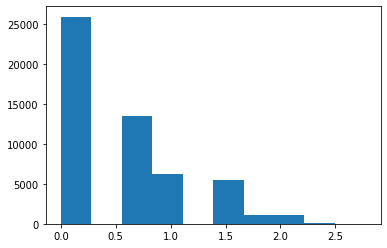

In [172]:
plt.hist(y)
plt.show()

In [173]:
y = quantile_gaussianize(y)

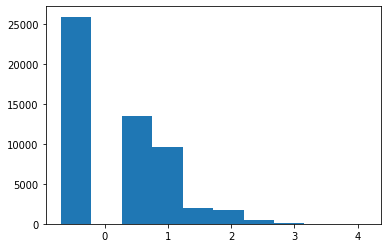

In [174]:
plt.hist(y)
plt.show()

In [175]:
n_cells = phenotype.shape[1]
W = ones((n_cells, 1))

In [176]:
del phenotype

In [177]:
start_time = time.time()
GG = G_expanded.values
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.5298891067504883 seconds ---


In [178]:
# del G_expanded
del G_sel

In [179]:
# get MAF
MAF_dir = mydir + "snps_with_maf_greaterthan0.05/"
myfile = MAF_dir+"chr"+str(chrom)+".SNPs.txt"
df_maf = pd.read_csv(myfile, sep="\t")

In [180]:
myfile

'/share/ScratchGeneral/anncuo/OneK1K/snps_with_maf_greaterthan0.05/chr20.SNPs.txt'

In [181]:
snps = G_expanded["snp"].values
mafs = np.array([])
for snp in snps:
    mafs = np.append(mafs, df_maf[df_maf["SNP"] == snp]["MAF"].values)

In [182]:
print("Running for gene {}".format(gene_name))

Running for gene RP11-290F20.3


In [183]:
# ?run_interaction

In [184]:
## goal: test for sex interactions only, still account for age and PCs (as well as sex) in background

In [185]:
start_time = time.time()
betas = estimate_betas(y=y, W=W, E=C.values[:,0:1], E1=C.values[:,0:12], E2=C.values[:,0:12], G=GG, hK=hK_expanded, maf=mafs)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4838.941029310226 seconds ---


In [186]:
beta_G = betas[0]
beta_GxC = betas[1][0]

In [187]:
beta_G_df = pd.DataFrame({"chrom":G_expanded.chrom.values,
               "betaG":beta_G,
               "variant":G_expanded.snp.values})

In [188]:
beta_G_df.head()

,chrom,betaG,variant
0,20,0.059806,20:48909078


In [ ]:
folder = mydir + "CRM_interaction/Monocytes_Mono_eQTLs/sex_interactions/betas/"
outfilename = f"{folder}{gene_name}"

In [ ]:
outfilename_betaGxC = outfilename+"_betaGxC.csv"

if os.path.exists(outfilename_betaGxC):
    print("File already exists, exiting")
    sys.exit()

In [ ]:
outfilename_betaGxC

In [ ]:
beta_G_df.to_csv(out_filename+"_betaG.csv")

In [ ]:
cells = phenotype["cell"].values
snps = G_expanded["variant"].values

In [ ]:
beta_GxC_df = pd.DataFrame(data = beta_GxC, columns = snps, index = cells) 
beta_GxC_df.head()

In [ ]:
beta_GxC_df.to_csv(outfilename_betaGxC)

In [ ]:
## took over an hour to run for one SNP!